In [1]:
from pathlib import Path
from utils import *


DATA_DIR = Path("out")
FIGURES_DIR = Path("figures")

### METG per Num Devices

In [ ]:
rsys = 'mpi'
accl = 'mi300a'
devices_per_worker = 1
date = '09_07_25'

bench =  f'tb_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='workers', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='workers')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

# df.query('workers == 1')
df

In [ ]:
agg_df = df.groupby(by=['devices', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    runtime_std=('wall_time', 'std')
).reset_index()


agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by='devices', as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on='devices')
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
agg_df

In [ ]:
plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='devices',
    style='devices',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)


In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='devices',
    style='devices',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    # xticks=df['task_granularity'].astype(str).unique(),
    xticks=[],
    # yticks=['0%', '25%', '50%', '75%', '100%'],
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
# Get METG(50%)
metg_df = agg_df[['devices', 'task_granularity', 'efficiency']].groupby('devices').apply(find_metg, include_groups=False).reset_index()

plot_meta = PlotMeta(
    x_axis='devices',
    y_axis='metg',
    hue=None,
    style=None,
    xlabel='Number of Devices',
    ylabel='Minimum Efficient Task Granularity (ms)',
    xticks=[],
    yticks=[],
    legend_title='',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale=False,
)

In [ ]:
benchs = [
    'tb_mpp_h100_08_07_25',
    'tb_mpp_mi300a_08_07_25',
    'tb_mpi_h100_09_07_25',
    'tb_mpi_mi300a_09_07_25',

]

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices'], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'task_granularity', 'efficiency']].groupby(['sys', 'accl', 'devices']).apply(find_metg, include_groups=False).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()

plot_meta = PlotMeta(
    x_axis='devices',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Number of Devices',
    ylabel='METG(50%) (ms)',
    xticks=[],
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
)

### METG per Num Deps

In [ ]:
rsys = 'mpi'
accl = 'mi300a'
devices_per_worker = 1
date = '10_07_25'

bench =  f'tb_deps_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='workers', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='workers')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    runtime_std=('wall_time', 'std')
).reset_index()


agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by='radix', as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on='radix')
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
agg_df.query('radix == 9')

In [ ]:
plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='radix',
    style='radix',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Num Deps',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_deps_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='radix',
    style='radix',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Num Deps',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_deps_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_deps_mpp_h100_10_07_25',
    'tb_deps_mpp_mi300a_10_07_25',
    'tb_deps_mpi_h100_10_07_25',
    'tb_deps_mpi_mi300a_10_07_25',
]

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'radix'], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'radix'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'radix', 'task_granularity', 'efficiency']].groupby(['sys', 'accl', 'devices', 'radix']).apply(find_metg, include_groups=False).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()

plot_meta = PlotMeta(
    x_axis='radix',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Number of Deps',
    ylabel='METG(50%) (ms)',
    xticks=[],
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'deps_metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
)

### METG Comm

In [ ]:
rsys = 'mpp'
accl = 'mi300a'
devices_per_worker = 1
date = '10_07_25'

bench =  f'tb_comm_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='workers', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='workers')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by='output', as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on='output')
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

In [ ]:
plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='output',
    style='output',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_comm_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='output',
    style='output',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_comm_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_comm_mpp_h100_10_07_25',
    'tb_comm_mpp_mi300a_10_07_25',
    'tb_comm_mpi_h100_10_07_25',
    'tb_comm_mpi_mi300a_10_07_25',
]

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'output'], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'radix', 'output'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'radix', 'output', 'task_granularity', 'efficiency']].groupby(
    ['sys', 'accl', 'devices', 'radix', 'output']).apply(find_metg, include_groups=False
).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()

plot_meta = PlotMeta(
    x_axis='output',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Output Size ($2^{x}$)',
    ylabel='METG(50%) (ms)',
    xticks=[],
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'com_metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
)

### METG Scalability

In [ ]:
rsys = 'mpi'
accl = 'h100'
devices_per_worker = 1
date = '13_07_25'

bench =  f'tb_scal_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='workers', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='workers')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'output', 'size', 'type', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by=['devices', 'type'], as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on=['devices', 'type'])
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

In [ ]:
type = 'stencil_1d'

plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='devices',
    style='devices',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df.query('type == @type'),
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_scal_{type}_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='devices',
    style='devices',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df.query('type == @type'),
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_scal_{type}_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_scal_mpp_h100_10_07_25',
    'tb_scal_mpp_mi300a_10_07_25',
    'tb_scal_mpi_h100_13_07_25',
    'tb_scal_mpi_mi300a_11_07_25',
]

devices_per_worker = 1

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'output', 'type', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'output', 'type'], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'radix', 'output', 'type'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'radix', 'output', 'type', 'task_granularity', 'efficiency']].groupby(
    ['sys', 'accl', 'devices', 'radix', 'output', 'type']).apply(find_metg, include_groups=False
).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper() + "-" + metg_df['type'].str.upper()

plot_meta = PlotMeta(
    x_axis='devices',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Num Devices',
    ylabel='METG(50%) (ms)',
    xticks=metg_df['devices'].astype('str').unique(),
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'scal_metg_line_2.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
    outside_legend=True,
)

### METG SCOMM

In [ ]:
rsys = 'mpi'
accl = 'mi300a'
devices_per_worker = 1
date = '14_07_25'

bench =  f'tb_scomm_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
# df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

# df['devices'] = df['workers'] * devices_per_worker
df['devices'] = devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='devices', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='devices')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'type', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by=['devices', 'output'], as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on=['devices', 'output'])
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

In [ ]:

plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='output',
    style='output',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_scomm_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='output',
    style='output',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    # dataset=df.query('workers == 1'),
    dataset=agg_df,
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_scomm_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_scomm_mpp_h100_14_07_25',
    'tb_scomm_mpp_mi300a_14_07_25',
    'tb_scomm_mpi_h100_14_07_25_2',
    'tb_scomm_mpi_mi300a_14_07_25',
]

devices_per_worker = 1

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'type', 'radix', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'type', 'radix', 'output', ], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'type', 'radix', 'output'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'type', 'radix', 'output', 'task_granularity', 'efficiency']].groupby(
    ['sys', 'accl', 'devices', 'type', 'radix', 'output']).apply(find_metg, include_groups=False
).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()
metg_df = metg_df[metg_df['output'] < 30]

plot_meta = PlotMeta(
    x_axis='output',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Output Size ($2^{x}$)',
    ylabel='METG(50%) (ms)',
    xticks=metg_df['output'].astype('str').unique(),
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'scomm_metg_line_2.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
    outside_legend=True,
)

### METG COMM Stencil

In [ ]:
rsys = 'mpp'
accl = 'h100'
devices_per_worker = 10
date = '14_07_25'

bench =  f'tb_comm_stencil_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
# df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

# df['devices'] = df['workers'] * devices_per_worker
df['devices'] = devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='devices', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='devices')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'type', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by=['devices', 'output'], as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on=['devices', 'output'])
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

In [ ]:
plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='output',
    style='output',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_comm_stencil_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='output',
    style='output',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    # dataset=df.query('workers == 1'),
    dataset=agg_df,
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_comm_stencil_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_comm_stencil_mpp_h100_14_07_25',
    'tb_comm_stencil_mpp_mi300a_14_07_25',
    'tb_comm_stencil_mpi_h100_14_07_25',
    'tb_comm_stencil_mpi_mi300a_14_07_25',
]

devices_per_worker = 10

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = devices_per_worker
# all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'type', 'radix', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'type', 'radix', 'output', ], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'type', 'radix', 'output'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'type', 'radix', 'output', 'task_granularity', 'efficiency']].groupby(
    ['sys', 'accl', 'devices', 'type', 'radix', 'output']).apply(find_metg, include_groups=False
).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()
metg_df = metg_df[metg_df['output'] < 30]

plot_meta = PlotMeta(
    x_axis='output',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Output Size ($2^{x}$)',
    ylabel='METG(50%) (ms)',
    xticks=metg_df['output'].astype('str').unique(),
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'comm_stencil_metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
    outside_legend=True,
)

### Strong Scaling

In [2]:
rsys = 'mpp'
accl = 'h100'
devices_per_worker = 1
date = '15_07_25'
rel = ''

bench =  f'tb_sscaling_stencil_5s_{rsys}_{accl}_{date}{rel}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
# df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
# df['devices'] = devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='devices', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='devices')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'type', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by=['devices'], as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on=['devices'])
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices']* np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

# Get METG(50%)
metg_df = agg_df[['devices', 'task_granularity', 'efficiency']].groupby(
    ['devices']).apply(find_metg, include_groups=False
).reset_index()

agg_df

,devices,radix,type,output,size,total_flops,total_tasks,runtime_mean,tflops_per_sec,tflops_per_task,max_tflops_per_sec,efficiency,task_granularity
0,1,5,stencil_1d,4,2,13421772800,200,0.067636,0.198441,0.000067,33.353242,0.594967,0.338181
1,1,5,stencil_1d,4,4,53687091200,200,0.069286,0.774857,0.000268,33.353242,2.323184,0.346432
2,1,5,stencil_1d,4,6,214748364800,200,0.068865,3.118398,0.001074,33.353242,9.34961,0.344325
3,1,5,stencil_1d,4,8,858993459200,200,0.071244,12.057088,0.004295,33.353242,36.149673,0.356219
4,1,5,stencil_1d,4,10,3435973836800,200,0.129386,26.556023,0.017180,33.353242,79.620515,0.646929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,10,5,stencil_1d,4,10,3435973836800,200,0.151437,22.689138,0.017180,219.290735,10.346601,7.571848
86,10,5,stencil_1d,4,12,13743895347200,200,0.214518,64.068764,0.068719,219.290735,29.216357,10.725894
87,10,5,stencil_1d,4,14,54975581388800,200,0.455106,120.797434,0.274878,219.290735,55.085517,22.755277
88,10,5,stencil_1d,4,16,219902325555200,200,1.426929,154.108809,1.099512,219.290735,70.276024,71.346449


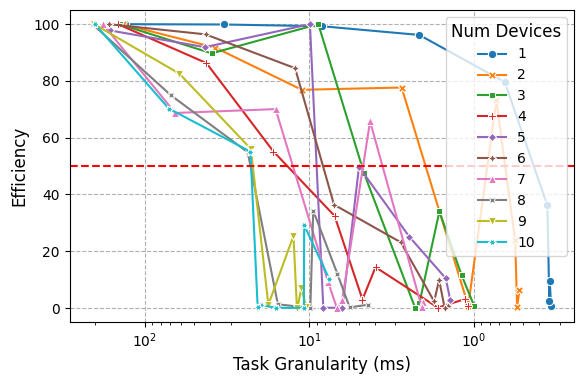

In [3]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='devices',
    style='devices',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)

generic_line_plot_err_bar(
    # dataset=df.query('workers == 1'),
    dataset=agg_df,
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_sscaling_stencil_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

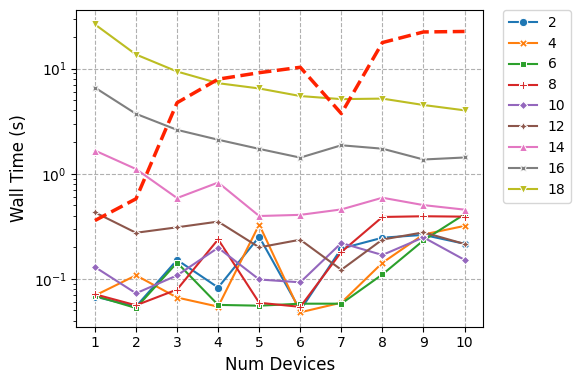

In [4]:
plot_meta = PlotMeta(
    x_axis='devices',
    y_axis='runtime_mean',
    hue='size',
    style='size',
    xlabel='Num Devices',
    ylabel='Wall Time (s)',
    xticks=agg_df['devices'].astype(str).unique(),
    yticks=[],
    legend_title='Problem Size ($2^{x}$)',
    legend_labels=[],
)

plot_meta_metg = PlotMeta(
    x_axis='devices',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Output Size ($2^{x}$)',
    ylabel='METG(50%) (ms)',
    xticks=metg_df['devices'].astype('str').unique(),
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

plots_meta = [plot_meta, plot_meta_metg]
datasets = [agg_df, metg_df]

generic_multi_line_plot_err_bar(
    datasets=datasets,
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_sstrong_scaling_stencil.pdf',
    plots_meta=plots_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
    outside_legend=True,
)

In [5]:
agg_df.query('size == 14')

,devices,radix,type,output,size,total_flops,total_tasks,runtime_mean,tflops_per_sec,tflops_per_task,max_tflops_per_sec,efficiency,task_granularity
6,1,5,stencil_1d,4,14,54975581388800,200,1.660529,33.10727,0.274878,33.353242,99.262524,8.302645
15,2,5,stencil_1d,4,14,54975581388800,200,1.10777,49.627252,0.274878,64.550616,76.881144,11.0777
24,3,5,stencil_1d,4,14,54975581388800,200,0.586362,93.757032,0.274878,93.757032,100.0,8.795433
33,4,5,stencil_1d,4,14,54975581388800,200,0.824214,66.700653,0.274878,120.963688,55.141055,16.484271
42,5,5,stencil_1d,4,14,54975581388800,200,0.3958,138.897306,0.274878,138.897306,100.0,9.895005
51,6,5,stencil_1d,4,14,54975581388800,200,0.405859,135.454751,0.274878,160.313571,84.493627,12.175781
60,7,5,stencil_1d,4,14,54975581388800,200,0.457151,120.257053,0.274878,171.584981,70.086002,16.00027
69,8,5,stencil_1d,4,14,54975581388800,200,0.590691,93.069911,0.274878,169.603964,54.874845,23.62765
78,9,5,stencil_1d,4,14,54975581388800,200,0.502603,109.381813,0.274878,195.124846,56.057348,22.617116
87,10,5,stencil_1d,4,14,54975581388800,200,0.455106,120.797434,0.274878,219.290735,55.085517,22.755277


In [6]:
metg_df

,devices,metg
0,1,0.358522
1,2,0.576933
2,3,4.737938
3,4,7.942130
4,5,9.149678
5,6,10.305171
6,7,3.736101
7,8,17.704872
8,9,22.343945
9,10,22.583557
